In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Path to the Helvetica font file
helvetica_font_path = '../../docs/helvetica.ttf'

# Add the font to Matplotlib's font manager
font_manager.fontManager.addfont(helvetica_font_path)

# Update rcParams to use the specific font throughout
plt.rcParams.update({'font.family': 'Helvetica'})

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

from rasterio.mask import mask
from shapely.geometry import mapping

import pandas as pd

from shapely.geometry import Point

import matplotlib

matplotlib.rcParams['font.family'] = 'Helvetica'

 # Demographics of Myanmar
 
To overcome gaps in official demographic statistics, the team has turned to private sector data sources. The Data Lab used algorithmically generated data such as that released by [Meta](https://dataforgood.facebook.com/dfg/docs/methodology-high-resolution-population-density-maps). 

Additionally, the team also extracted the [Relative Wealth Index](https://dataforgood.facebook.com/dfg/tools/relative-wealth-index) data from Meta which helps identify differences in standard of living in the population. 

 ## Data

 ### High Resolution Population Density

In partnership with the Center for International Earth Science Information Network (CIESIN) at Columbia University, Meta uses state-of-the-art computer vision techniques to identify buildings from publicly accessible mapping services to create these population datasets. These maps are available at 30-meter resolution. These maps aren’t built using Facebook data and instead rely on applying machine vision AI to satellite imagery and census information. This data is made accessible to this team through the [Development Data Partnership](https://datapartnership.org/). **The available version of the data was last updated in 2019.** 

The Population Data is demographically disaggregated into the following categories
* Men
* Women
* Children under 5
* Elderly
* Women of Reproductive Age (15-49)
* Youth (15-24)

 ### Relative Wealth Index

The Meta Relative Wealth Index predicts the relative standard of living within countries using privacy protecting connectivity data, satellite imagery, and other novel data sources. To calculate this index, Meta uses measurements of household wealth collected through *face-to-face surveys conducted by the United States Agency for International Development* with 1,457,315 unique households living in 66,819 villages in 56 different LMICs around the world. Following this, they use spatial markers to link villages to non-traditional data sources , including satellite imagery, cellular network data, topographic maps, and *privacy protecting connectivity data from Facebook*. They process the non-traditional data using deep learning and other computational algorithms, which convert the raw data to a set of quantitative features for each village. They use these features to train a supervised machine learning model that predicts the relative wealth of each populated 2.4km2 grid cell on the planet, even in regions where no ground truth data exists (Chi et. al., 2022).

The Relative Wealth Index is a number that compared the wealth within the country where negative RWI implies poorer areas and positive RWI implies richer areas. 

 ## Methodology and Implementation

The data extracted from Meta was then aggregated to different admin levels using the shapefiles available on [Myanmar information Management Unit](https://themimu.info/news/updated-shapefiles). These datasets are made available on [SharePoint](https://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FData%20Lab%2FMyanmar%20Economic%20Monitor%2FData&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5). 

## Findings

In [9]:
MYANMAR = gpd.read_file('../../data/shapefiles/mmr_polbnda_adm3_250k_mimu/mmr_polbnda_adm3_250k_mimu.shp')

In [10]:
hrsl_men = pd.read_csv('../../data/population/Myanmar-demographics/MMR_men_2019-08-03.csv')
hrsl_women = pd.read_csv('../../data/population/Myanmar-demographics/MMR_women_2019-08-03.csv')
hrsl_children = pd.read_csv('../../data/population/Myanmar-demographics/MMR_children_under_five_2019-08-03.csv')
hrsl_elderly = pd.read_csv('../../data/population/Myanmar-demographics/MMR_elderly_60_plus_2019-08-03.csv')

In [11]:
hrsl_men.rename(columns = {'population':'population_men'}, inplace=True)
hrsl_women.rename(columns = {'population':'population_women'}, inplace=True)
hrsl_elderly.rename(columns = {'population':'population_elderly'}, inplace=True)
hrsl_children.rename(columns = {'population':'population_children'}, inplace=True)

hrsl = hrsl_men.merge(hrsl_women, on = ['latitude', 'longitude']).merge(hrsl_elderly).merge(hrsl_children)

In [12]:
hrsl['population'] = hrsl['population_men'] + hrsl['population_women']

In [13]:
def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [14]:
hrsl = convert_to_gdf(hrsl)

In [15]:
MYANMAR.to_crs('EPSG:4326', inplace=True)

In [16]:
hrsl_adm3 = MYANMAR.sjoin(hrsl)

In [17]:
hrsl_adm3 = hrsl_adm3.groupby(['ST', 'ST_PCODE', 'DT', 'DT_PCODE', 'TS', 'TS_PCODE']).sum( ['population_men', 'population_women', 'population_elderly',
       'population_children', 'population']).reset_index()
hrsl_adm3 = MYANMAR[['ST', 'ST_PCODE', 'DT', 'DT_PCODE', 'TS', 'TS_PCODE', 'geometry']].merge(hrsl_adm3[['ST', 'ST_PCODE', 'DT', 'DT_PCODE', 'TS', 'TS_PCODE', 'population_men',
       'population_women', 'population_elderly', 'population_children','population']])

hrsl_adm3 = gpd.GeoDataFrame(hrsl_adm3, crs="EPSG:4326", geometry='geometry')

In [12]:
hrsl_adm3.to_file('../../data/population/myanmar_adm3_hrsl.shp', format = 'ESRI Shapefile')

C:\Users\sahit\AppData\Local\Temp\ipykernel_3672\616041592.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hrsl_adm3.to_file('../../data/population/myanmar_adm3_hrsl.shp', format = 'ESRI Shapefile')


### Popultion Estimates

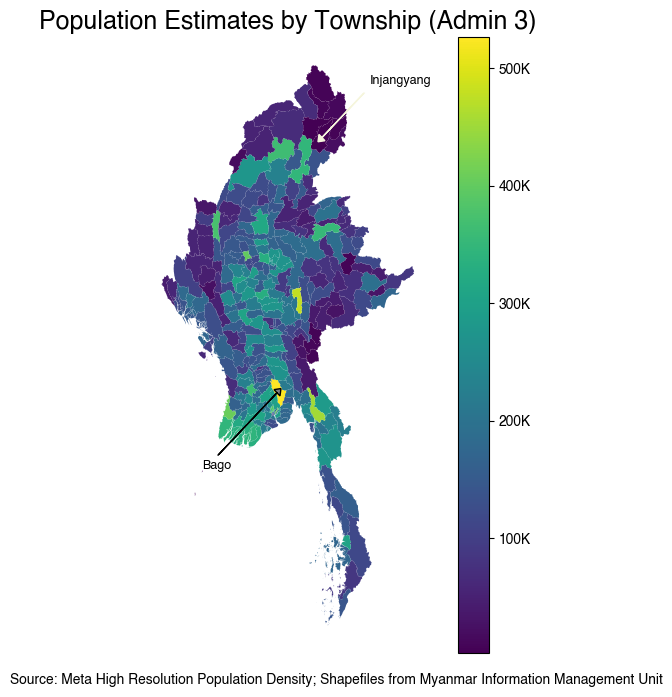

In [88]:
from matplotlib.ticker import FixedLocator

fig, ax = plt.subplots(figsize=(8,8))
plt.axis('off')
hrsl_adm3.plot(column = 'population', legend = True, ax=ax)
ax.set_title('Population Estimates by Township (Admin 3)', fontsize=18, x=0.5,y=1)

highest_centroid = hrsl_adm3.sort_values(by='population', ascending = False).iloc[0]['geometry'].centroid

plt.arrow(highest_centroid.x -2.15, highest_centroid.y-2.15, 2.1, 2.1, head_width=0.3, head_length=0.2, fc='grey', ec='black')

text_dx = 2.7  # Adjust for text placement
text_dy = 2.7  # Adjust for text placement
ax.text(highest_centroid.x - text_dx, highest_centroid.y - text_dy, hrsl_adm3.sort_values(by='population', ascending = False).iloc[0]['TS'], fontsize=9, ha='left', va='bottom')

lowest_centroid = hrsl_adm3.sort_values(by='population').iloc[0]['geometry'].centroid

plt.arrow(lowest_centroid.x +1.5, lowest_centroid.y+1.5, -1.5, -1.5, head_width=0.3, head_length=0.2, fc='beige', ec='beige')

text_dx = 1.7  # Adjust for text placement
text_dy = 1.7  # Adjust for text placement
ax.text(lowest_centroid.x + text_dx, lowest_centroid.y + text_dy, hrsl_adm3.sort_values(by='population').iloc[0]['TS'], fontsize=9, ha='left', va='bottom')

fig = ax.figure
cbar = fig.axes[1]  # This assumes the colorbar is the second axes object

ticks = cbar.get_yticks()  # Get the current tick locations

# Now, create custom tick labels, assuming you want to scale them for 'per 1000' units
tick_labels = [f"{tick/1000:.0f}K" for tick in ticks]

# Use FixedLocator to set the tick locations along with the new labels
cbar.yaxis.set_major_locator(FixedLocator(ticks))
cbar.set_yticklabels(tick_labels)

subtitle_text = "Source: Meta High Resolution Population Density; Shapefiles from Myanmar Information Management Unit"
ax.text(-0.5, -0.05, subtitle_text, transform=ax.transAxes, fontsize=10, ha='left');

#### Observations and Limitations

* The data is from 2019. Myanmar has seen a lot of conflict and political unrest, aside from a pandemic since then. The numbers shown here do not reflect any of the recent changes in population movement. 
* The regions close to the Bangladesh border (Cox's Bazar) and the regions close to the Chinese border are less populated compared to regions close to the Thailand border.
* Bago, a township north of Yangon is the most populous township. 

In [40]:
rwi = pd.read_csv('../../data/relative-wealth/MMR_relative_wealth_index.csv')
rwi = convert_to_gdf(rwi)

In [42]:
myanmar_rwi_adm3 = MYANMAR[['ST', 'DT', 'TS', 'geometry']].merge(MYANMAR.sjoin(rwi).groupby(['ST', 'DT', 'TS']).mean('rwi').reset_index())

In [43]:
highest_rwi = myanmar_rwi_adm3.sort_values(by='rwi', ascending = False).iloc[0]
lowest_rwi = myanmar_rwi_adm3.sort_values(by='rwi', ascending = True).iloc[0]

### Relative Wealth Distribution

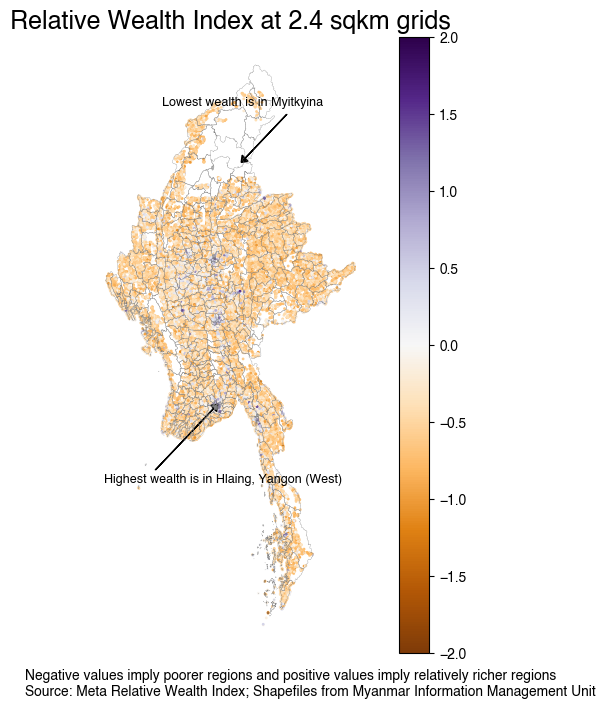

In [86]:
fig, ax = plt.subplots(figsize=(8,8))
plt.axis('off')
myanmar_rwi_adm3.boundary.plot(ax=ax, linewidth=0.2, color='grey')
rwi.plot(column = 'rwi', legend = True, ax=ax, markersize=1, cmap = 'PuOr', vmin=-2, vmax=2)

highest_centroid = highest_rwi['geometry'].centroid

plt.arrow(highest_centroid.x -2.15, highest_centroid.y-2.15, 2.1, 2.1, head_width=0.3, head_length=0.2, fc='grey', ec='black')

text_dx = 4  # Adjust for text placement
text_dy = 2.7  # Adjust for text placement
ax.text(highest_centroid.x - text_dx, highest_centroid.y - text_dy, f'Highest wealth is in {highest_rwi["TS"]}, {highest_rwi["DT"]}', fontsize=9, ha='left', va='bottom')

lowest_centroid = lowest_rwi['geometry'].centroid

plt.arrow(lowest_centroid.x +1.5, lowest_centroid.y+1.5, -1.5, -1.5, head_width=0.3, head_length=0.2, fc='black', ec='black')

text_dx = -3  # Adjust for text placement
text_dy = 1.7  # Adjust for text placement
ax.text(lowest_centroid.x + text_dx, lowest_centroid.y + text_dy, f'Lowest wealth is in {lowest_rwi["TS"]}', fontsize=9, ha='left', va='bottom')


plt.title('Relative Wealth Index at 2.4 sqkm grids', fontsize=18, ha='center')

subtitle_text = "Negative values imply poorer regions and positive values imply relatively richer regions\nSource: Meta Relative Wealth Index; Shapefiles from Myanmar Information Management Unit"
ax.text(-0.25, -0.07, subtitle_text, transform=ax.transAxes, fontsize=10, ha='left');

#### Observations and Limitations

* The algorithm Meta used uses input data collected before [2018](https://www.pnas.org/doi/10.1073/pnas.2113658119). This means that any recent changes in wealth are not reflected in the figures.
* The most populous district (Bago) is not the richest one. The SEZ Yangon (West) is wealthier. 

### Comparing Relative Wealth in the Townships in Bago District and Yangon (West)

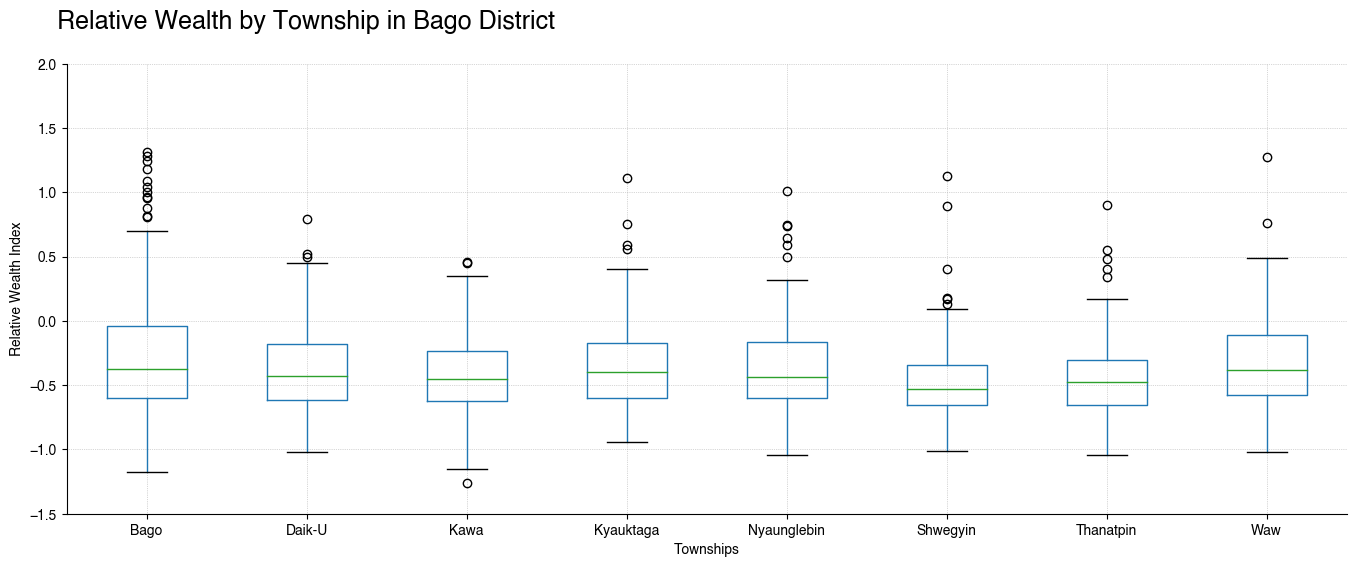

In [73]:
fig, ax = plt.subplots(figsize=(16,6))
df = MYANMAR.sjoin(rwi)
df = df[df['DT'].isin(['Bago'])][['TS', 'rwi']]
df.boxplot(column='rwi', by='TS', ax=ax)

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)

ax.set_xlabel('Townships')
ax.set_ylabel('Relative Wealth Index')

ax.grid(True, which='both', linestyle=':', linewidth=0.5)

ax.set_ylim([-1.5, 2])

ax.set_title(' ', x=0.17, fontsize=14)

plt.suptitle('Relative Wealth by Township in Bago District', fontsize=18, x=0.25, y=0.99);

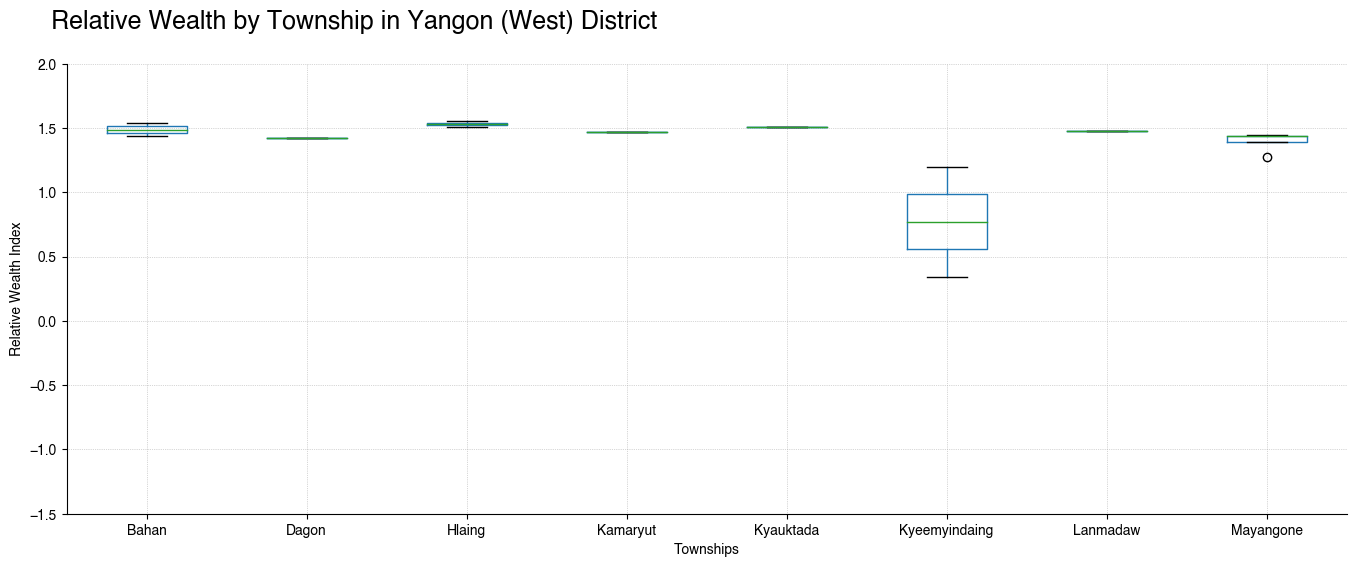

In [72]:
fig, ax = plt.subplots(figsize=(16,6))
df = MYANMAR.sjoin(rwi)
df = df[df['DT'].isin(['Yangon (West)'])][['TS', 'rwi']]
df.boxplot(column='rwi', by='TS', ax=ax)

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)

ax.set_xlabel('Townships')
ax.set_ylabel('Relative Wealth Index')

ax.set_ylim([-1.5, 2])

ax.grid(True, which='both', linestyle=':', linewidth=0.5)

ax.set_title(' ', x=0.17, fontsize=14)

plt.suptitle('Relative Wealth by Township in Yangon (West) District', fontsize=18, x=0.28, y=0.99);

### Observations and Limitations

* Yangon (West) is significantly wealthier. However, Hlaing, the richest township is also much smaller in area compared to the Bago township. 
* There is a lot of income inequality in the most populous district of Myanmar with the average being relatively poor than the rest of the nation. This average is likely brought down by the extremely ric parts of Yangon (West). 